In [1]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import pickle
from functools import partial

# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')

import PlotDefault
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c
# import imp
# imp.reload(KalmanInversion )
# imp.reload(NeuralNet)
# jupyter nbconvert --to script 'Indirect_NN.ipynb'


In [2]:
TRAINING_TYPE = "indirect" # indirect   indirect_res

if TRAINING_TYPE == "direct":
    trained_net = torch.load("direct.nn")
else:
    (save_folder, uki_iter) = ("indirect_NN" , 49) if TRAINING_TYPE=="indirect" else ("indirect_NN_res" , 1)
 
    uki_obj = pickle.load( open( save_folder + "/ukiobj-" + str(uki_iter) + ".dat", "rb" ) )
    trained_net = NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])






print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[-1.0722,  6.0617],
        [ 0.2684, -1.7796],
        [ 0.0231,  5.2584],
        [-0.2239, -1.7501],
        [ 2.7076,  1.5399],
        [-3.1021,  1.7134],
        [ 2.7208,  2.2172],
        [-0.6610,  5.5616],
        [ 0.3252,  2.1799],
        [-3.5881, -1.9009]], requires_grad=True)
Parameter containing:
tensor([ 9.4231,  0.9961, -3.0267, -0.4033, -2.9932, -1.8995, -2.2489, -5.9737,
        -2.3851,  0.1145], requires_grad=True)
Parameter containing:
tensor([[ 1.3341, -0.3244,  0.3919,  0.3079,  0.2945, -1.0254, -1.5115,  0.1015,
          0.4834, -0.1883]], requires_grad=True)
Parameter containing:
tensor([-0.5992], requires_grad=True)


# Direct test

In [3]:
N_y = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

N_data = len(data_dirs)
closure_mean,  q_mean, dq_dy_mean = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dy_mean[i, :] = load_data(data_dirs[i])

L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
dy = yy[1] - yy[0]

omega_jet = np.zeros(N_y)
omega_jet[0:N_y//2] = 1.0
omega_jet[N_y//2:N_y] = -1.0
q_jet = omega_jet + beta*yy


# TODO: clean data
chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)    #q_jet[-chop_l:] 
    dq_dy_mean[i, 0:chop_l] = np.linspace(beta, dq_dy_mean[i,chop_l-1],  chop_l)
    dq_dy_mean[i, -chop_l:] = np.linspace(dq_dy_mean[i, -chop_l], beta, chop_l)
    
q_mean_abs = np.fabs(q_mean)  
mu_f = closure_mean/dq_dy_mean

# TODO: clip and filter the data
mu_f[mu_f >= 0.1 ] = 0.0
mu_f[mu_f <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f[i,:] = scipy.ndimage.gaussian_filter1d(mu_f[i,:], 5)

../Utility/NeuralNet.py:492: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()


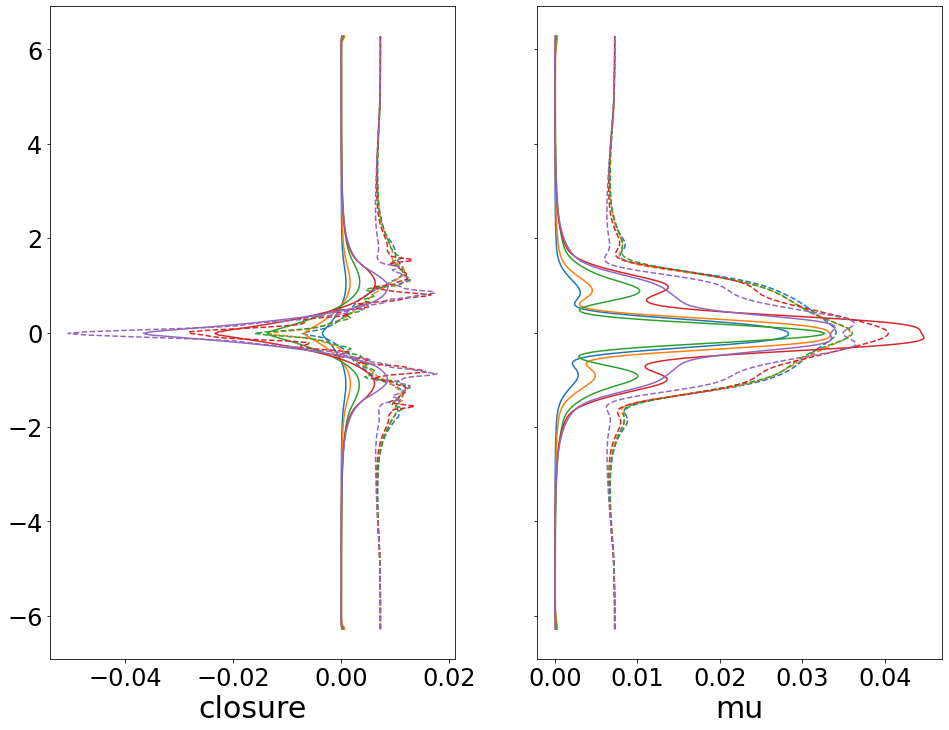

In [4]:
x_train = torch.from_numpy(np.stack((np.abs(q_mean).flatten(), dq_dy_mean.flatten())).T.astype(np.float32)) 
y_pred = NeuralNet.net_eval(x=x_train, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_data).reshape((N_data, N_y))

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,:], yy, color="C"+str(i))
    ax[0].plot(y_pred[i,:]*dq_dy_mean[i,:], yy, "--", color="C"+str(i))
    
    ax[1].plot(mu_f[i,:], yy, color="C"+str(i))
    ax[1].plot(y_pred[i,:], yy, "--", color="C"+str(i))
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("mu")

fig.savefig("Point-Jet-Training-" + TRAINING_TYPE + "Direct-Test.png")



# Plug-in test

In [17]:
beta = 1.0

def point_jet(tau_inv, trained_net):
    print("start ", tau_inv)

    Nx = 384
    omega_jet = np.zeros(Nx)
    omega_jet[0:Nx//2] = 1.0
    omega_jet[Nx//2:Nx] = -1.0
    L = 4*np.pi
    yy = np.linspace(-L/2.0, L/2.0, Nx)
    q_jet = omega_jet + beta*yy



    tau = 1/float(tau_inv)
    data_dir = "../data/beta_1.0_Gamma_1.0_relax_" + tau_inv + "/"
    dq_dy = scipy.io.loadmat(data_dir+"data_dq_dy.mat")["data_dq_dy"]
    closure = scipy.io.loadmat(data_dir+"data_closure_cons.mat")["data_closure_cons"]
    w = scipy.io.loadmat(data_dir+"data_w.mat")["data_w"]
    q = scipy.io.loadmat(data_dir+"data_q.mat")["data_q"]

    _, Ny, Nt = q.shape
    q_mean_ref = np.mean(q[0, :, Nt//2:], axis=1)
    w_mean_ref = np.mean(w[0, :, Nt//2:], axis=1)


    nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    model = lambda q, xx, res : nummodel(nn_model, q, xx, res)

    dt, Nt, save_every = 1.0e-4, 200000, 1000
    yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = L)
    q_mean_pred = np.mean(q_pred[Nt//(2*save_every):, :], axis=0)
    
    
    return yy, q_mean_ref, q_mean_pred, q_pred

tau_invs = ["0.005", "0.06", "0.2"]
q_mean_ref, q_mean_pred =  np.zeros((len(tau_invs), N_y)), np.zeros((len(tau_invs), N_y))


for i in range(len(tau_invs)):
    _, q_mean_ref[i,:], q_mean_pred[i,:], _ = point_jet(tau_invs[i], trained_net)
    

start  0.005
start  0.06
start  0.2


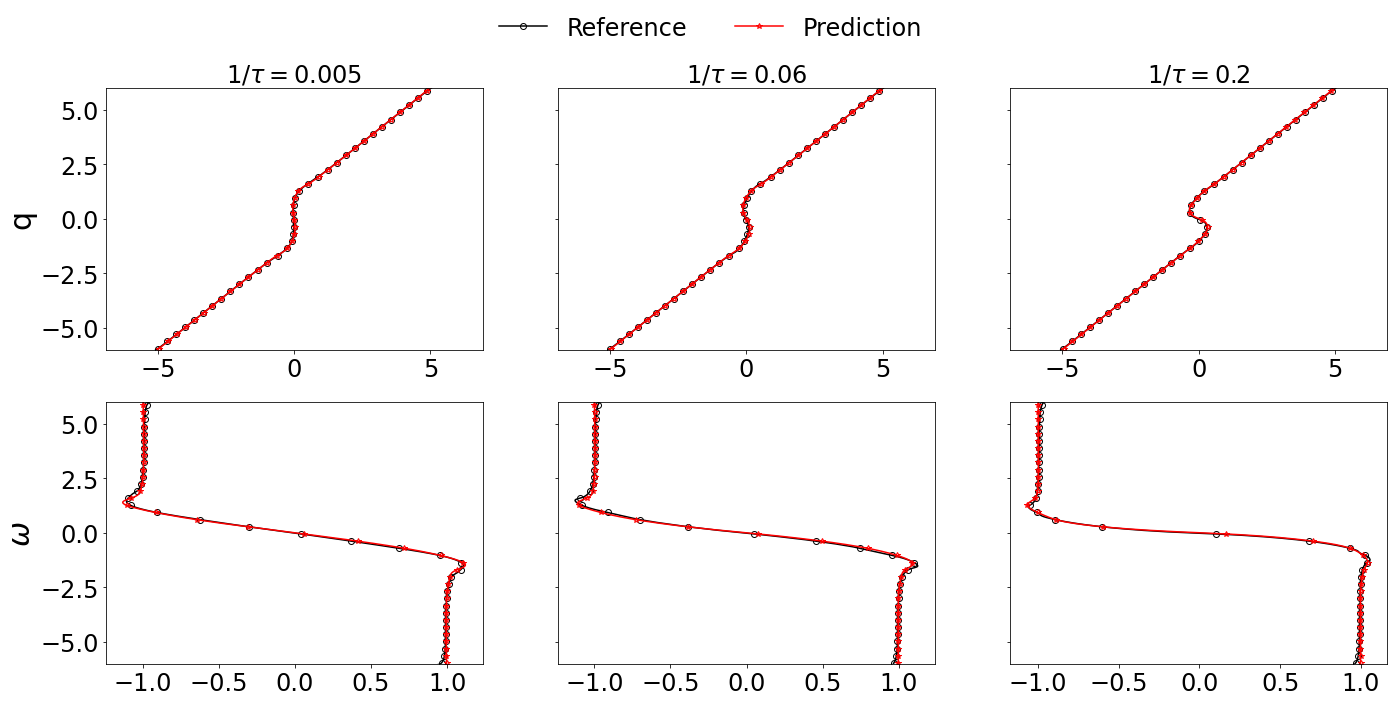

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(20,10))
markevery = 10

omega_mean_ref = np.copy(q_mean_ref)
omega_mean_pred = np.copy(q_mean)

for i in range(3):
    omega_mean_ref[i,:] = q_mean_ref[i,:] - beta*yy
    omega_mean_pred[i,:] = q_mean_pred[i,:] - beta*yy
    
    color, marker, label = "black", "o", "Reference"
    ax[0, i].plot(q_mean_ref[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)
    ax[1, i].plot(omega_mean_ref[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color)
    
    color, marker, label = "red", "*", "Prediction"
    ax[0, i].plot(q_mean_pred[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)
    ax[1, i].plot(omega_mean_pred[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)
    
    
    ax[0, i].set_title(r"$1/\tau = $"+tau_invs[i])
    
ax[0, 0].set_ylabel("q")
ax[1, 0].set_ylabel(r"$\omega$")

ax[0, 0].set_ylim([-6.0,6.0])
ax[1, 0].set_ylim([-6.0,6.0])

handles, labels = ax[0,0].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.05,top=0.85,left=0.08,right=0.97)
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.98),ncol=2,frameon=False)
plt.savefig("Point_Jet-Indirect_Test.pdf")





